In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = 'cuda' if torch.cuda.is_available() else "cpu"

model_ckpt = 'kakaocorp/kanana-nano-2.1b-base'

model = AutoModelForCausalLM.from_pretrained(
  model_ckpt,
  torch_dtype = torch.bfloat16,
  trust_remote_code = True,
).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_ckpt, padding_size = 'left')
tokenizer.pad_token = tokenizer.eos_token # 문장의 종료를 나타내는 토큰: kanana에서는 128001

c:\Users\user\anaconda3\envs\torchenv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--kakaocorp--kanana-nano-2.1b-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
qna_list = []

with open("./data/company.txt", "r") as f:
  for line in f:
    qna = line.strip().split("|")
    input_str = qna[0] + " " + qna[1] 
    # 각 question, input 데이터와 그것들의 인코딩 id값인 q_ids, input_ids 생성
    item = {'q':qna[0], 'input':input_str, "q_ids":tokenizer.encode(qna[0]), 'input_ids':tokenizer.encode(input_str)}
    qna_list.append(item)
    
max_length = max(len(item['input_ids']) for item in qna_list)

for res in qna_list[:5]:
  print(res)
  
print(max_length)

{'q': '카카오는 어떤 회사야? ', 'input': '카카오는 어떤 회사야?   카카오는 IT 회사로 다양한 플랫폼을 운영하고 있어.', 'q_ids': [128000, 101436, 101436, 125301, 112700, 127798, 90759, 30, 220], 'input_ids': [128000, 101436, 101436, 125301, 112700, 127798, 90759, 30, 256, 103236, 101436, 125301, 8871, 127798, 17835, 118696, 107375, 124689, 100796, 120, 18359, 107065, 101360, 112795, 13]}
{'q': '네이버는 어떤 기업이야? ', 'input': '네이버는 어떤 기업이야?   네이버는 검색엔진으로 시작한 국내 대표 포털 사이트야.', 'q_ids': [128000, 101886, 122273, 16969, 112700, 119864, 115242, 30, 220], 'input_ids': [128000, 101886, 122273, 16969, 112700, 119864, 115242, 30, 256, 103315, 122273, 16969, 115036, 108733, 86351, 43139, 94821, 24486, 120380, 116865, 99969, 117419, 117240, 90759, 13]}
{'q': '삼성전자는 무슨 일을 해? ', 'input': '삼성전자는 무슨 일을 해?   삼성전자는 전자제품과 반도체를 생산하는 글로벌 기업이야.', 'q_ids': [128000, 111690, 33931, 66965, 112953, 119528, 124851, 61816, 30, 220], 'input_ids': [128000, 111690, 33931, 66965, 112953, 119528, 124851, 61816, 30, 256, 122851, 66965, 112953, 57519, 26799, 38187, 

### 파인튜닝 전의 응답 확인

In [7]:
# 질문 추출 및 질문 추가
questions = [qna['q'] for qna in qna_list] 
questions.append("너에 대해서 설명해봐")
questions.append("인공지능의 장점은 뭐야?")
questions.append("IT 기업에 대해서 얘기해봐")

input_ids = tokenizer(
  questions,
  padding = True, # 길이 불일치시 패딩 토큰으로 채움
  return_tensors = 'pt'
)['input_ids'].to(device)

model.eval()
with torch.no_grad():
  output = model.generate(
    input_ids,
    max_new_tokens = 32,
    do_sample = False,
  )
  
output_list = output.tolist()

for i, output in enumerate(output_list):
    print(f"Q{i}: {tokenizer.decode(output, skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Q0: 카카오는 어떤 회사야? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q1: 네이버는 어떤 기업이야? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q2: 삼성전자는 무슨 일을 해? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q3: 현대자동차는 어떤 회사야? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q4: LG는 어디에 강점이 있어? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q5: 쿠팡은 어떤 서비스를 해? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q6: 배달의민족은 무슨 앱이야? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q7: 토스는 어떤 기능이 있어? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q8: 라인은 어떤 메신저야? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q9: 카카오뱅크는 뭐하는 곳이야? 1. 카카오뱅크는 카카오가 만든 인터넷 전문 은행입니다. 2. 카카오뱅크
Q10: 엘지유플러스는 무슨 회사야? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q11: SK텔레콤은 어떤 기술을 개발해? [공지] [모집] 2024년 1월, 2월, 3월, 4월, 5월,
Q12: 당근마켓은 어떤 앱이야? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q13: 직방은 무슨 서비스를 해? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q14: 뽀로로는 누구야? [서평] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365
1일 1페이지, 세상
Q15: 무신사는 어떤 쇼핑몰이야? [서평] 1

In [20]:
for qa in qna_list:
  token_ids = qa['input_ids']
  print(len(token_ids))
  print(tokenizer.decode(token_ids[1:])) # 현재 begin_of_text 토큰이 함께 존재함 

25
카카오는 어떤 회사야?   카카오는 IT 회사로 다양한 플랫폼을 운영하고 있어.
25
네이버는 어떤 기업이야?   네이버는 검색엔진으로 시작한 국내 대표 포털 사이트야.
30
삼성전자는 무슨 일을 해?   삼성전자는 전자제품과 반도체를 생산하는 글로벌 기업이야.
27
현대자동차는 어떤 회사야?   현대자동차는 자동차를 설계하고 제조하는 대기업이야.
30
LG는 어디에 강점이 있어?   LG는 가전제품과 디스플레이 분야에서 기술력을 가진 기업이야.
33
쿠팡은 어떤 서비스를 해?   쿠팡은 빠른 로켓배송으로 유명한 온라인 쇼핑몰이야.
33
배달의민족은 무슨 앱이야?   배달의민족은 음식을 주문할 수 있는 배달 플랫폼이야.
28
토스는 어떤 기능이 있어?   토스는 송금, 투자, 보험 등 다양한 금융 서비스를 제공해.
27
라인은 어떤 메신저야?   라인은 일본에서 인기 있는 메신저로 네이버가 개발했어.
33
카카오뱅크는 뭐하는 곳이야?   카카오뱅크는 모바일 기반의 인터넷 전문 은행이야.
34
엘지유플러스는 무슨 회사야?   엘지유플러스는 통신과 IPTV 서비스를 제공하는 회사야.
38
SK텔레콤은 어떤 기술을 개발해?   SK텔레콤은 5G와 인공지능 등 첨단 통신 기술을 개발해.
33
당근마켓은 어떤 앱이야?   당근마켓은 지역 주민끼리 중고 물품을 거래하는 앱이야.
28
직방은 무슨 서비스를 해?   직방은 부동산 매물 정보를 모바일로 제공하는 서비스야.
27
뽀로로는 누구야?   뽀로로는 아이들에게 인기 있는 한국 애니메이션 캐릭터야.
29
무신사는 어떤 쇼핑몰이야?   무신사는 스트리트 패션을 중심으로 한 온라인 편집숍이야.
35
브런치는 무엇을 위한 플랫폼이야?   브런치는 작가들이 글을 쓰고 공유할 수 있는 플랫폼이야.
30
마켓컬리는 어떤 특징이 있어?   마켓컬리는 신선식품을 새벽에 배송해주는 서비스야.
33
지그재그는 어떤 앱이야?   지그재그는 여성 쇼핑몰 상품을 모아 보여주는 패션 앱이야.
35
왓챠는 무슨 서비스를 해?   왓챠는 영화

In [19]:
for qa in qna_list:
  token_ids = qa['q_ids']
  print(len(token_ids))
  print(tokenizer.decode(token_ids))

9
<|begin_of_text|>카카오는 어떤 회사야? 
9
<|begin_of_text|>네이버는 어떤 기업이야? 
10
<|begin_of_text|>삼성전자는 무슨 일을 해? 
11
<|begin_of_text|>현대자동차는 어떤 회사야? 
11
<|begin_of_text|>LG는 어디에 강점이 있어? 
12
<|begin_of_text|>쿠팡은 어떤 서비스를 해? 
13
<|begin_of_text|>배달의민족은 무슨 앱이야? 
9
<|begin_of_text|>토스는 어떤 기능이 있어? 
10
<|begin_of_text|>라인은 어떤 메신저야? 
15
<|begin_of_text|>카카오뱅크는 뭐하는 곳이야? 
14
<|begin_of_text|>엘지유플러스는 무슨 회사야? 
14
<|begin_of_text|>SK텔레콤은 어떤 기술을 개발해? 
12
<|begin_of_text|>당근마켓은 어떤 앱이야? 
10
<|begin_of_text|>직방은 무슨 서비스를 해? 
9
<|begin_of_text|>뽀로로는 누구야? 
11
<|begin_of_text|>무신사는 어떤 쇼핑몰이야? 
14
<|begin_of_text|>브런치는 무엇을 위한 플랫폼이야? 
12
<|begin_of_text|>마켓컬리는 어떤 특징이 있어? 
12
<|begin_of_text|>지그재그는 어떤 앱이야? 
12
<|begin_of_text|>왓챠는 무슨 서비스를 해? 


### 파인튜닝

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

EOT = 128001 # instruct 모델과 다름

class MyDataset(Dataset):
    def __init__(self, qna_list, max_length):
        self.input_ids = []
        self.target_ids = []

        for qa in qna_list:
            token_ids = qa['input_ids']
            input_chunk = token_ids
            # begin_of_token 제거하여 target_chunk에 저장 
            target_chunk = token_ids[1:]
            
            # 뒷 부분을 end of text 토큰으로 채워줌 
            # 전체 시퀀스를 패딩까지 포함해서 모델 입력값으로 사용 
            input_chunk += [EOT]* (max_length - len(input_chunk))
            target_chunk +=  [EOT]* (max_length - len(target_chunk))
            
            # token_ids를 저장한 input_chunk에서 "begin_of_text"를 제외하여 한 글자가 짧기 때문에 -1 
            len_ignore = len(qa['q_ids']) - 1 
            
            # Pytorch에서 CroosEntropyLoss를 사용할 때, label의 값이 -100으로 된 부분은 loss 계산에서 무시
            # question, 질문 부분을 -100 값으로 채워서 무시 
            target_chunk[:len_ignore] = [-100] * len_ignore 

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

dataset = MyDataset(qna_list, max_length=max_length)

# 현재는 데이터셋이 작아서 batch_size를 2로 설정하였지만 큰 데이터셋의 경우 16, 32 등으로 변경 
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=False)

In [22]:
i = iter(train_loader)

In [23]:
x, y = next(i)

y_temp = y[0].tolist()
y_temp = [x for x in y_temp if x != -100] # -100은 제외하고 디코딩

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y_temp))

<|begin_of_text|>토스는 어떤 기능이 있어?   토스는 송금, 투자, 보험 등 다양한 금융 서비스를 제공해.<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|>
 토스는 송금, 투자, 보험 등 다양한 금융 서비스를 제공해.<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|>


### 모델 훈련

- 데이터셋이 작으므로 validation은 생략

In [24]:
torch.manual_seed(42)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-6, weight_decay=0.01)
print(device)

cuda


In [26]:
import torch.nn.functional as F 
import torch.nn as nn

tokens_seen, global_step = 0, -1

losses = []

for epoch in range(10):
    model.train()  # Set model to training mode
    
    epoch_loss = 0
    for input_batch, target_batch in train_loader:
      
        optimizer.zero_grad() 
        # 동일 장치로 변경  
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch).logits # 뒤에 .logits를 붙여서 tensor만 가져옴
        
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        #loss = nn.CrossEntropyLoss(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        
        loss.backward()
        
        optimizer.step() 
        
        tokens_seen += input_batch.numel()
        global_step += 1

        print(f"{global_step} Tokens seen: {tokens_seen}")

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "model_" + str(epoch).zfill(3) + ".pth")

0 Tokens seen: 76
1 Tokens seen: 152
2 Tokens seen: 228
3 Tokens seen: 304
4 Tokens seen: 380
5 Tokens seen: 456
6 Tokens seen: 532
7 Tokens seen: 608
8 Tokens seen: 684
9 Tokens seen: 760
Epoch: 0, Loss: 5.7484375
10 Tokens seen: 836
11 Tokens seen: 912
12 Tokens seen: 988
13 Tokens seen: 1064
14 Tokens seen: 1140
15 Tokens seen: 1216
16 Tokens seen: 1292
17 Tokens seen: 1368
18 Tokens seen: 1444
19 Tokens seen: 1520
Epoch: 1, Loss: 5.56875
20 Tokens seen: 1596
21 Tokens seen: 1672
22 Tokens seen: 1748
23 Tokens seen: 1824
24 Tokens seen: 1900
25 Tokens seen: 1976
26 Tokens seen: 2052
27 Tokens seen: 2128
28 Tokens seen: 2204
29 Tokens seen: 2280
Epoch: 2, Loss: 5.45
30 Tokens seen: 2356
31 Tokens seen: 2432
32 Tokens seen: 2508
33 Tokens seen: 2584
34 Tokens seen: 2660
35 Tokens seen: 2736
36 Tokens seen: 2812
37 Tokens seen: 2888
38 Tokens seen: 2964
39 Tokens seen: 3040
Epoch: 3, Loss: 5.29375
40 Tokens seen: 3116
41 Tokens seen: 3192
42 Tokens seen: 3268
43 Tokens seen: 3344
44 To

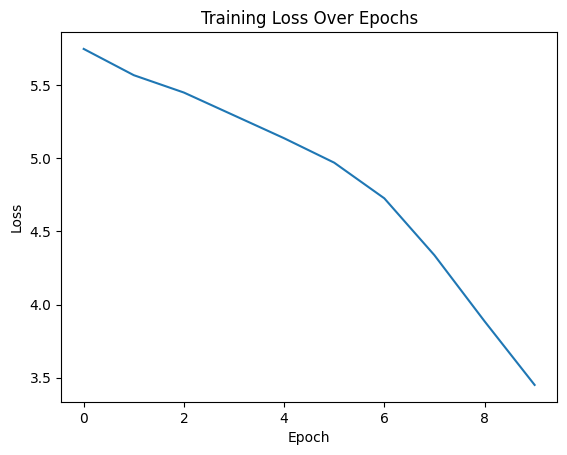

In [27]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

### 모델 결과 확인

In [28]:
# 파인튜닝 후에 어떻게 응답하는지 확인
model.load_state_dict(torch.load("model_009.pth", map_location=device, weights_only=True))
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 1792)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=1792, out_features=3072, bias=False)
          (k_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=1792, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (up_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (down_proj): Linear(in_features=8064, out_features=1792, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((1792,), eps=1e-05)
    (rotary_emb

In [29]:
questions = [ qna['q'] for qna in qna_list]
questions.append("카카오는 어떤 회사야?")
questions.append("대기업에 대해서 얘기해봐")
questions.append("카나나 모델에 대해서 설명해봐.")
questions.append("이처럼 인간처럼 생각하고 행동하는 AI 모델은 ")
questions.append("인공지능의 장점은")

for i, q in enumerate(questions):

    input_ids = tokenizer(
        q,
        padding=True,
        return_tensors="pt",
    )["input_ids"].to("cuda")

    # print(type(model))

    model.eval()
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=32,
            attention_mask = (input_ids != 0).long(),
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            # temperature=1.2,
            # top_k=5
        )

    output_list = output.tolist()

    print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")

Q0: 카카오는 어떤 회사야?  카카오는 대한민국의 대표적인 IT 기업으로, 메신저 서비스인 카카오톡을 비롯하여 다양한 서비스를 제공하고 있습니다
Q1: 네이버는 어떤 기업이야?  네이버는 대한민국의 대표적인 인터넷 기업으로, 다양한 서비스와 플랫폼을 제공하고 있습니다. 네이버는 검색 엔진, 포털
Q2: 삼성전자는 무슨 일을 해? 1. 삼성전자는 반도체를 만드는 회사야. 2. 삼성전자는 휴대폰을 만드는 회사야. 3.
Q3: 현대자동차는 어떤 회사야?  현대자동차는 대한민국의 대표적인 자동차 제조업체로, 1967년에 설립되었습니다. 현대자동차는 자동차 산업에서 세계
Q4: LG는 어디에 강점이 있어?  LG는 전자제품을 만드는 회사야.  LG는 전자제품을 만드는 회사야.  LG는 전자제품
Q5: 쿠팡은 어떤 서비스를 해? 1. 쿠팡은 온라인 쇼핑몰이야. 2. 쿠팡은 온라인 쇼핑몰이면서 배달도
Q6: 배달의민족은 무슨 앱이야?  배달의민족은 음식 배달을 위한 앱이야.
Q7: 토스는 어떤 기능이 있어?  토스는 간편송금, 송금, 계좌이체, 이체, 송금, 송금, 송금, 송금, 송금
Q8: 라인은 어떤 메신저야? 1. 라인은 일본의 메신저야. 2. 라인은 한국의 메신저야. 3. 라인은 미국의 메신
Q9: 카카오뱅크는 뭐하는 곳이야?  카카오뱅크는 카카오가 만든 인터넷 전문 은행이야.  카카오뱅크는 카카오
Q10: 엘지유플러스는 무슨 회사야?  엘지유플러스는 통신 서비스를 제공하는 회사야.
Q11: SK텔레콤은 어떤 기술을 개발해?  SK텔레콤은 5G 기술을 개발하고 있어. 5G는 4G보다 더 빠른 속도로 데이터를 전송
Q12: 당근마켓은 어떤 앱이야?  당근마켓은 중고거래를 할 수 있는 앱이야.  당근마켓은 지역 기반의 중고거래 플랫폼
Q13: 직방은 무슨 서비스를 해?  직방은 부동산 중개 플랫폼이야.  부동산을 사고팔 때 필요한 정보를 제공해.  예를
Q14: 뽀로로는 누구야? 1. 뽀로로의 탄생 뽀로로는 1997년 11월 11일, 한국의 애니메이션 제작사
Q15: